# Practical 8: CNNs and RNNs

The aim of this lab is the learn to implement Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNN) in Keras.

We will do this be implementing building CNN and RNN models for the task of *Human Activity Recognition* (HAR). This is the problem of predicting what a person is doing based on a trace of their movement using accelerometers sensors.

The data, and a description of the task we are doing can be found __[here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)__.

If you have not already done so, please download a copy of the daa form the __[UCI website](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/)__ before the lab (the *UCI HAR Dataset.zip* folder). After downloading, unzip it and place it in the same folder you are running this program from.

<hr style="border:1px solid black"> </hr>

### Step 1 Set-Up
Import all toolboxes need to support the tutorial

In [1]:
import numpy as np
import pandas as pd

from numpy import mean
from numpy import std
from numpy import dstack

from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from tensorflow.keras.utils import to_categorical

from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import preprocessing, Normalization

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2022-05-23 15:55:05.836513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-05-23 15:55:05.836537: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Observing Model training** the following function will be used to obsevere the behaviour of the models after they have been trained. It plots the loss and accuracy of model after every training epoch

In [2]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

<hr style="border:1px solid black"> </hr>

### Step 2 Load the data, partition and set up pre-processing

The data was collected from 30 subjects aged between 19 and 48 years old performing one of six standard activities while wearing a waist-mounted smartphone that recorded the movement data. The activities performed were:
- Walking
- Walking Upstairs
- Walking Downstairs
- Sitting
- Standing
- Laying

There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each has 3 axises (x,y,z) of data. This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.56 seconds of data, or 128 time steps. These windows of data correspond to the windows of engineered features (rows) in the previous section.

This means that one row of data has (128 * 9), or 1,152 elements

The following block of code are the functions needed to exract this data

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix='UCI HAR Dataset/'):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix='UCI HAR Dataset/'):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix='UCI HAR Dataset/'):
    # load all train
    trainX, trainy = load_dataset_group('train')
    # load all test
    testX, testy = load_dataset_group('test')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy

Call the `load_dataset` function, then split the training data into a training and a validation set

In [4]:
# Extract defined training and test splits
X_train, y_train, X_test, y_test = load_dataset()

# Parameters needed for setting the input and output shapes in our models
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

The following block of code utiliser the Keras preprocessing layers API to build Keras-native input pre-processing step. We implemetn the normiliser in the a `create_model()` function below

In [9]:
normalizer = Normalization()
normalizer.adapt(X_train)

2022-05-23 15:56:45.556145: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33878016 exceeds 10% of free system memory.


<hr style="border:1px solid black"> </hr>

###  Step 4 Building a CNN

As in the previous lab, we build our CNN via a keras __[sequential](https://keras.io/guides/sequential_model/)__ model. 

**Questions:** 
- Describe the architecture of the model coded below.
- What is the purpose of the `BatchNormalization()` layer?

In [12]:
# define the keras model
def create_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(n_timesteps,n_features)))
    model.add(normalizer)
    model.add(Conv1D(filters=32, kernel_size=))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(n_outputs, activation='softmax'))
    print(model.summary())
    return model

Compile the model then build it to start training

**Question** What is the purpose of the `shuffle=True` and `validation_split = 0.2` commands in the `model.fit` function? 

In [13]:
model = create_model()

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 9)           19        
 n)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 32)           1472      
                                                                 
 batch_normalization_1 (Batc  (None, 124, 32)          128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1984)              0         
                                                      

Plot the accuracies and model losses obtained over training

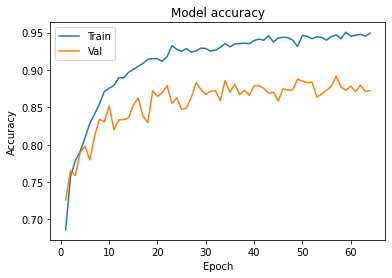

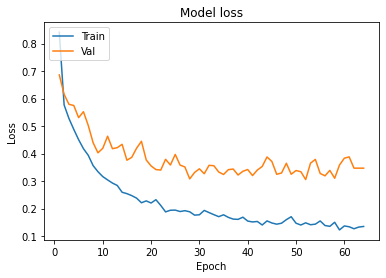

In [21]:
plot_learningCurve(history, EPOCHS)

Observe the models performance on the test set? Does this seem reasonable for this experiement? 

Evaluate on test data
93/93 [==============================] - 0s 2ms/step - loss: 0.7101 - accuracy: 0.8273
test loss, test acc: [0.7101251482963562, 0.8272819519042969]
93/93 [==============================] - 0s 2ms/step


<AxesSubplot:>

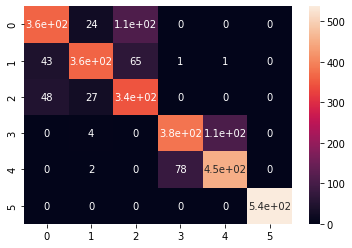

In [22]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)

### Exercise: Alter the model
- First, change the number of filters in the first layer to be size 64, and the kernal size to be 5. Observe how this alters the performance of the system.
- Then, update the model again. Add in a new convolution, batch normalisation and max pooling layers. These should be added between the current max pooling and flattening layer. The size of the convolutional layer should be 32, the kernel size should be 3. The max pooling size should be 2 and stride 1. Observe how this alters the performance of the system.
- Finally, Add ReLU activations to both convolutional layers. Observe how this alters the performance of the system.

<hr style="border:1px solid black"> </hr>

###  Step 5 Building a LSTM-RNN

Again, we build our LSTM via a keras __[sequential](https://keras.io/guides/sequential_model/)__ model. 

**Question:** Describe the architecture of the model coded below

In [27]:
# define the keras model
def create_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(n_timesteps,n_features)))
    model.add(normalizer)
    model.add(LSTM(64))
    model.add(BatchNormalization())
    model.add(Dense(n_outputs, activation='softmax'))
    print(model.summary())
    return model

Compile the model then build it to start training

**Question** Why has `shuffle` been set to `False` in the below code

In [28]:
model = create_model()

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=False,
    verbose=2
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 9)           19        
 n)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                18944     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 19,609
Trainable params: 19,462
Non-trainable params: 147
_________________________________________________________________
None
Epoch 1/64
184/184 - 10s - loss: 1.2641 - a

Epoch 59/64
184/184 - 9s - loss: 0.1167 - accuracy: 0.9679 - val_loss: 0.3445 - val_accuracy: 0.9327 - 9s/epoch - 46ms/step
Epoch 60/64
184/184 - 9s - loss: 0.1184 - accuracy: 0.9634 - val_loss: 0.4547 - val_accuracy: 0.9184 - 9s/epoch - 48ms/step
Epoch 61/64
184/184 - 8s - loss: 0.1405 - accuracy: 0.9599 - val_loss: 0.5745 - val_accuracy: 0.8756 - 8s/epoch - 46ms/step
Epoch 62/64
184/184 - 8s - loss: 0.1272 - accuracy: 0.9631 - val_loss: 0.4345 - val_accuracy: 0.9354 - 8s/epoch - 46ms/step
Epoch 63/64
184/184 - 8s - loss: 0.1250 - accuracy: 0.9674 - val_loss: 0.3315 - val_accuracy: 0.9368 - 8s/epoch - 46ms/step
Epoch 64/64
184/184 - 8s - loss: 0.1055 - accuracy: 0.9687 - val_loss: 0.4846 - val_accuracy: 0.9279 - 8s/epoch - 45ms/step


Plot the accuracies and model losses obtained over training

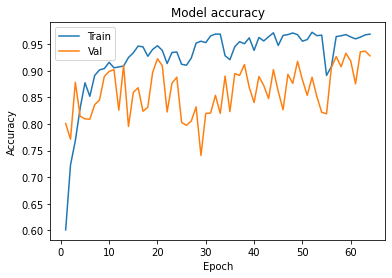

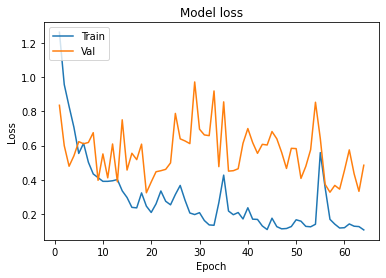

In [29]:
plot_learningCurve(history, EPOCHS)

Evaluate on test data
93/93 [==============================] - 1s 14ms/step - loss: 0.9954 - accuracy: 0.8714
test loss, test acc: [0.9953835010528564, 0.8713946342468262]
93/93 [==============================] - 2s 14ms/step


<AxesSubplot:>

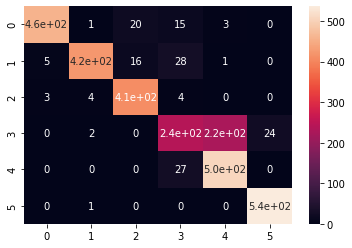

In [30]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)

### Exercise: Alter the model
- First, change the number of nodes in the first layer to be size 64. Then add in a new LSTM layer between the batch normalisation and dense layers. This layer should have 32 nodes. Perform Batch Normalisation after this layer as well. **Note**, in the first LSTM layer, you will need to set `return_sequences=True` so that the so that the second LSTM layer has a three-dimensional sequence input
- Observe how this alters the performance of the system.
- Then add this layer `model.add(Dropout(0.5))` in directly after both batch normalisation layers. What is the purpose of doing this? 
- Alter the code to run Gated Reccurent Units (GRUs) instead of LSTMs. Observe how this alters the performance of the system.

In [50]:
def create_stacked_LSTM():
    model = Sequential()
    model.add(InputLayer(input_shape=(n_timesteps,n_features)))
    model.add(normalizer)
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(32, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dense(n_outputs, activation='softmax'))
    
    print(model.summary())
    return model

def regularised_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(n_timesteps, n_features)))
    model.add(normalizer)
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_outputs,activation='softmax'))
    
    print(model.summary())
    return model

In [37]:
complex_model = create_stacked_LSTM()

complex_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = complex_model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=False,
    verbose=2
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 9)           19        
 n)                                                              
                                                                 
 lstm_6 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_7 (Batc  (None, 128, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                      

Epoch 55/64
184/184 - 15s - loss: 0.0715 - accuracy: 0.9762 - val_loss: 0.7653 - val_accuracy: 0.8838 - 15s/epoch - 83ms/step
Epoch 56/64
184/184 - 15s - loss: 0.0897 - accuracy: 0.9696 - val_loss: 0.7885 - val_accuracy: 0.8389 - 15s/epoch - 82ms/step
Epoch 57/64
184/184 - 16s - loss: 0.1562 - accuracy: 0.9549 - val_loss: 0.5238 - val_accuracy: 0.8763 - 16s/epoch - 85ms/step
Epoch 58/64
184/184 - 15s - loss: 0.1137 - accuracy: 0.9687 - val_loss: 0.5086 - val_accuracy: 0.8708 - 15s/epoch - 84ms/step
Epoch 59/64
184/184 - 15s - loss: 0.1515 - accuracy: 0.9566 - val_loss: 0.5869 - val_accuracy: 0.8688 - 15s/epoch - 83ms/step
Epoch 60/64
184/184 - 16s - loss: 0.1032 - accuracy: 0.9668 - val_loss: 0.7771 - val_accuracy: 0.8185 - 16s/epoch - 84ms/step
Epoch 61/64
184/184 - 16s - loss: 0.0915 - accuracy: 0.9716 - val_loss: 0.8012 - val_accuracy: 0.7893 - 16s/epoch - 85ms/step
Epoch 62/64
184/184 - 16s - loss: 0.0784 - accuracy: 0.9743 - val_loss: 0.8547 - val_accuracy: 0.8069 - 16s/epoch - 87

Evaluate on test data
93/93 [==============================] - 2s 22ms/step - loss: 1.1298 - accuracy: 0.7950
test loss, test acc: [1.1298075914382935, 0.795045793056488]
93/93 [==============================] - 3s 22ms/step


<AxesSubplot:>

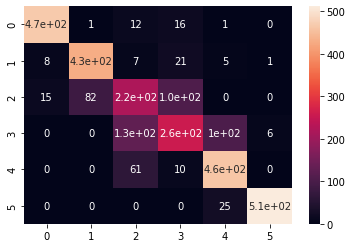

In [40]:
print("Evaluate on test data")
results = complex_model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

y_pred = complex_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)

<hr style="border:1px solid black"> </hr>

### Exercise: Early Stopping

Implement an __[early stopping](https://keras.io/api/callbacks/early_stopping/)__ strategy for the validation loss on both networks. 

**Note** the default `patience` value is 0. This means training is terminated as soon as the performance measure gets worse from one epoch to the next. This may not be the ideal value. 

**Note** don't run the `plot_learningCurve(history, EPOCHS)` function with early stopping, it will error.

In [38]:
from keras.callbacks import EarlyStopping


In [51]:
es = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

model3 = regularised_model()

model3.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model3.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=False,
    verbose=2,
    callbacks=[es]
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 9)           19        
 n)                                                              
                                                                 
 lstm_18 (LSTM)              (None, 128, 64)           18944     
                                                                 
 batch_normalization_19 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 128, 64)           0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 batch_normalization_20 (Bat  (None, 32)             